# Мобильное приложение стартапа

Для анализа предлагается стартап, который продаёт продукты питания. 

**Цель исследования** - разобраться, как ведут себя пользователи мобильного приложения.

**Задачи исследования**
* Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
* Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

**Ход исследования**

Исследование пройдет в 6 этапов:

1. Обзор данных;
2. Предобработка данных;
3. Изучение и проверка данных;
4. Изучение воронки событий;
5. Изучение результатов эксперимента;
6. Вывод.

## Шаг 1. Обзор данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
from scipy import stats


Читаем файл `logs_exp.csv` и сохраняем его в переменную `data`.

In [2]:
try: 
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except: 
    data = pd.read_csv('logs_exp.csv', sep='\t')

Выводим на экран первые 10 строк таблицы `logs_exp.csv`, а также общую информацию о таблице.

In [3]:
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В таблице 4 столбца. Согласно документации к данным:
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

В данных замечены ошибки: 
* неправильный тип данных в столбце `EventTimestamp`;
* yарушение стиля в названиях колонок.

## Шаг 2. Предобработка данных

### 2.1 Изменение типов данных 

Добавим столбец даты и времени, а также отдельный столбец дат

In [5]:
data['date_time'] = pd.to_datetime(data['EventTimestamp'], unit='s') #добавление столбца даты и времени
data['date'] = data['date_time'].dt.date #добавление столбца дат
data #результат

,EventName,DeviceIDHash,EventTimestamp,ExpId,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


### 2.2 Стиль заголовков

In [6]:
data.columns #выводим названия столбцов датафрейма costs

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId', 'date_time',
       'date'],
      dtype='object')

Переименуем колонки таблиц в соответвие со 'змеиным регистром':

In [7]:
data = data.rename( 
    columns={
        'EventName': 'event_name',
        'DeviceIDHash': 'device_id_hash',
        'EventTimestamp': 'event_timestamp',
        'ExpId': 'exp_id',
    }
)

### 2.3 Дубликаты

Для качества анализа данные необходимо проверить на дубликаты. Сначала займемся явными дубликатами.

In [8]:
# подсчёт явных дубликатов
data.duplicated().sum()

413

In [9]:
# удаление явных дубликатов (с удалением старых индексов и формированием новых)
data = data.drop_duplicates().reset_index(drop=True)

In [10]:
# проверка на отсутствие явных дубликатов
data.duplicated().sum()

0

Теперь проверим неявные дубкаты. Для этого выведем уникальные значения столбцов.

In [11]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Неявных дубликатов нет

In [12]:
data.info() #проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


**Вывод**


На этапе предобработки были исправлены следующие ошибки:
* стили заголовков;
* неверные типы данных;
* явные дубликаты.

Теперь можно приступить к следующему шагу.

## Шаг 3. Изучение и проверка данных

Посмотрим, сколько всего событий и пользователей в логе

In [13]:
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Событий всего 5. Самое распространенное - MainScreenAppear.

In [14]:
data['device_id_hash'].value_counts()

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
                       ... 
6888746892508752          1
6671109879025379318       1
1223708690315846789       1
5229230634268921313       1
2408195006658927235       1
Name: device_id_hash, Length: 7551, dtype: int64

In [15]:
data.groupby('device_id_hash').agg({'event_name' : 'count'}).median()


event_name    20.0
dtype: float64

Пользователей в логе 7551. В среднем на пользователя приходится 20 событий.

Посмотрим, данными за какой период мы располагаем.

In [16]:
data['date'].min()

datetime.date(2019, 7, 25)

In [17]:
data['date'].max()

datetime.date(2019, 8, 7)

В даннных максимальная дата - 7 августа 2019, минимальная - 25 июля 2019. 

Построим гистограмму по дате и времени, чтобы убедиться, что за все даты анализа полные данные.

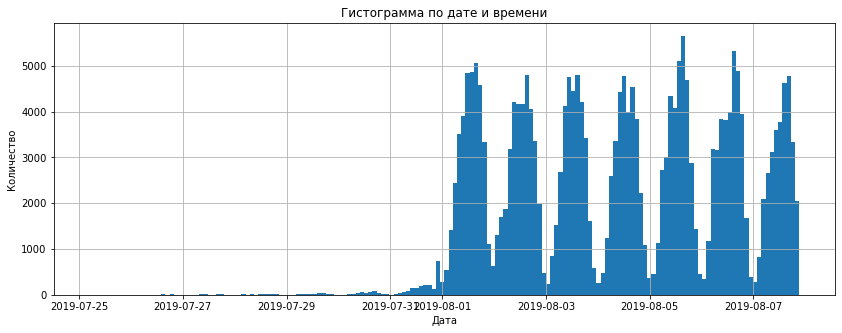

In [18]:
data['date_time'].hist(bins=7*24, figsize=(14, 5));
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

In [19]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
new_data = data.loc[data['date'] >= '2019-08-01'].reset_index()

Проверим, много ли событий и пользователей потеряли, отбросив старые данные. Также проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [20]:
len(data)- len(new_data)

2826

In [21]:
len(data['device_id_hash'].unique())- len(new_data['device_id_hash'].unique())

17

In [22]:
new_data['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

Отбросив эти даты, было потеряно 2826 событий и 17 пользователей. Пользователи остались из всех экспериментальных групп.

**Вывод**

В логе 5 событий, самое распространенное - `MainScreenAppear`. Пользователей в логе 7551, в среднем на пользователя приходится 20 событий. В даннных максимальная дата - 7 августа 2019, минимальная - 25 июля 2019. До 1 августа данные не полные, их можно отбросить. Связано это с тем, что технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Отбросив эти даты, было потеряно 2826 событий и 17 пользователей. Пользователи остались из всех экспериментальных групп.

## Шаг 4. Изучение воронки событий

Посмотрим, какие события есть в логах и как часто они встречаются. 

<Figure size 1080x288 with 0 Axes>

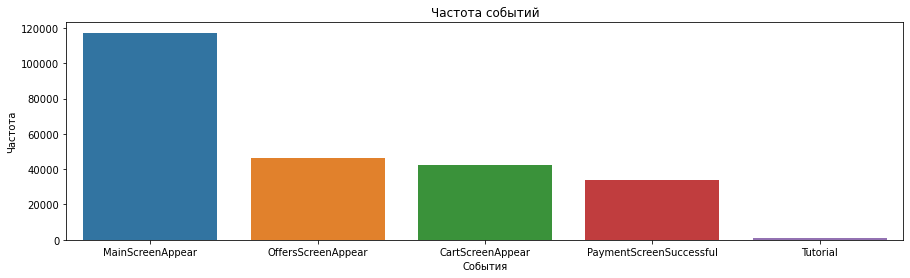

In [23]:
plt.figure(figsize=(15,4))

data_demo = new_data.groupby('event_name')\
                     .agg(count=('exp_id','count'))\
                     .reset_index()\
                     .sort_values(by='count', ascending=False)

plt.figure(figsize=(15,4))
sns.barplot(data=data_demo, x='event_name', y='count')
plt.title('Частота событий')
plt.xlabel('События')
plt.ylabel('Частота')
plt.show()

Чаще всего производится действие `MainScreenAppear`.

Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие.

In [24]:
sales_funnel = new_data.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
sales_funnel.rename(columns={'device_id_hash': 'users'}, inplace=True)
sales_funnel['fraction'] = sales_funnel['users'] / len(new_data['device_id_hash'].unique())
sales_funnel

,users,fraction
event_name,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


Из этой таблицы можно предположить, что воронка выстраивается так - `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`. `Tutorial` в воронке будет лишним.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [25]:
sales_funnel['fraction'] = sales_funnel['users']/sales_funnel['users'].shift()
sales_funnel

,users,fraction
event_name,,
MainScreenAppear,7419,NaN
OffersScreenAppear,4593,0.619086
CartScreenAppear,3734,0.812976
PaymentScreenSuccessful,3539,0.947777
Tutorial,840,0.237355


Больше всего пользователей теряется при переходе к шагу `OffersScreenAppear`. Больше половины! 

От первого события до оплаты доходит примерно 47%.

**Вывод**

Чаще всего производится действие `MainScreenAppear`. Воронка выстраивается так - `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`. Больше всего пользователей теряется при переходе к шагу `OffersScreenAppear`. Больше половины! От первого события до оплаты доходит примерно 47%.

## Шаг 5. Изучение результатов эксперимента

Посмотрим, сколько пользователей в каждой экспериментальной группе

In [26]:
new_data['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

В `246` группе 79302 пользователей, в `247` - 77022, в `248` - 84563. 

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками `246` и `247`.


In [27]:
exp_246 = new_data[new_data['exp_id'] == 246].groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
exp_247 = new_data[new_data['exp_id'] == 247].groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
exp_248 = new_data[new_data['exp_id'] == 248].groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
exp_246_247 = exp_246.add(exp_247).combine_first(exp_246).combine_first(exp_247)

#для события MainScreenAppear
successes1 = exp_246.loc['MainScreenAppear']
successes2 = exp_247.loc['MainScreenAppear']
trials1 = new_data[new_data['exp_id'] == 246]['device_id_hash'].nunique()
trials2 = new_data[new_data['exp_id'] == 247]['device_id_hash'].nunique()

def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01):
    # пропорция успехов в первой группе:
    p1 = successes1/trials1

    # пропорция успехов во второй группе:
    p2 = successes2/trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")  
        
check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [28]:
#для события OffersScreenAppear
successes1 = exp_246.loc['OffersScreenAppear']
successes2 = exp_247.loc['OffersScreenAppear']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [29]:
#для события CartScreenAppear
successes1 = exp_246.loc['CartScreenAppear']
successes2 = exp_247.loc['CartScreenAppear']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [30]:
#для события PaymentScreenSuccessful
successes1 = exp_246.loc['PaymentScreenSuccessful']
successes2 = exp_247.loc['PaymentScreenSuccessful']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными. Следовательно, статистической разницы между группами 246 и 247 нет.

Аналогично проверим группы 246 и 248.

In [31]:
#для события MainScreenAppear
successes1 = exp_246.loc['MainScreenAppear']
successes2 = exp_248.loc['MainScreenAppear']
trials1 = new_data[new_data['exp_id'] == 246]['device_id_hash'].nunique()
trials2 = new_data[new_data['exp_id'] == 248]['device_id_hash'].nunique()
        
check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [32]:
#для события OffersScreenAppear
successes1 = exp_246.loc['OffersScreenAppear']
successes2 = exp_248.loc['OffersScreenAppear']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [33]:
#для события CartScreenAppear
successes1 = exp_246.loc['CartScreenAppear']
successes2 = exp_248.loc['CartScreenAppear']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [34]:
#для события PaymentScreenSuccessful
successes1 = exp_246.loc['PaymentScreenSuccessful']
successes2 = exp_248.loc['PaymentScreenSuccessful']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистической разницы нет. Контрольные группы 246 и 248 можно считать идентичными. Далее проверим 247 и 248.

In [35]:
#для события MainScreenAppear
successes1 = exp_247.loc['MainScreenAppear']
successes2 = exp_248.loc['MainScreenAppear']
trials1 = new_data[new_data['exp_id'] == 247]['device_id_hash'].nunique()
trials2 = new_data[new_data['exp_id'] == 248]['device_id_hash'].nunique()
        
check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [36]:
#для события OffersScreenAppear
successes1 = exp_247.loc['OffersScreenAppear']
successes2 = exp_248.loc['OffersScreenAppear']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [37]:
#для события CartScreenAppear
successes1 = exp_247.loc['CartScreenAppear']
successes2 = exp_248.loc['CartScreenAppear']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [38]:
#для события PaymentScreenSuccessful
successes1 = exp_247.loc['PaymentScreenSuccessful']
successes2 = exp_248.loc['PaymentScreenSuccessful']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистической разницы нет. Контрольные группы 247 и 248 можно считать идентичными. 

Также проверим объединенную группу (246 и 247) и 248.

In [39]:
#для события MainScreenAppear
successes1 = exp_246_247.loc['MainScreenAppear']
successes2 = exp_248.loc['MainScreenAppear']
trials1 = new_data.query('exp_id == (246, 247)')
trials1  = trials1['device_id_hash'].nunique()
trials2 = new_data[new_data['exp_id'] == 248]['device_id_hash'].nunique()
        
check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [40]:
#для события OffersScreenAppear
successes1 = exp_246_247.loc['OffersScreenAppear']
successes2 = exp_248.loc['OffersScreenAppear']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [41]:
#для события CartScreenAppear
successes1 = exp_246_247.loc['CartScreenAppear']
successes2 = exp_248.loc['CartScreenAppear']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [42]:
#для события PaymentScreenSuccessful
successes1 = exp_246_247.loc['PaymentScreenSuccessful']
successes2 = exp_248.loc['PaymentScreenSuccessful']

check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01)

p-значение:  [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Все события не являются разными. Из этого можно сделать вывод, что после изменения шрифта воронка событий осталась прежней.

Уровень значимости был выбран 0.01 для всех тестов. Следовательно, каждый десятый раз можно получать ложный результат. 

**Вывод**
В `246` группе 79302 пользователей, в `247` - 77022, в `248` - 84563. Cтатистической разницы между контрольными группами нет. Также, нет статистической разницы между контрольной группой и эксперименатальной. Из этого можно сделать вывод, что после изменения шрифта воронка событий осталась прежней. 
Уровень значимости был выбран 0.01 для всех тестов. Следовательно, каждый десятый раз можно получать ложный результат.

## Общий вывод

Для анализа предлагался стартап, который продаёт продукты питания. Цель исследования - разобраться, как ведут себя пользователи мобильного приложения.

На этапе предобработки были исправлены следующие ошибки: стили заголовков; неверные типы данных; явные дубликаты.

В логе 5 событий, самое распространенное - `MainScreenAppear`. Пользователей в логе 7551, в среднем на пользователя приходится 20 событий. В даннных максимальная дата - 7 августа 2019, минимальная - 25 июля 2019. До 1 августа данные не полные, их можно отбросить. Связано это с тем, что технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Отбросив эти даты, было потеряно 2826 событий и 17 пользователей. Пользователи остались из всех экспериментальных групп.

Воронка выстраивается так - `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`. Больше всего пользователей теряется при переходе к шагу `OffersScreenAppear`. Больше половины! От первого события до оплаты доходит примерно 47%.

В `246` группе 79302 пользователей, в `247` - 77022, в `248` - 84563. Cтатистической разницы между контрольными группами нет. Также, нет статистической разницы между контрольной группой и эксперименатальной. Из этого можно сделать вывод, что после изменения шрифта воронка событий осталась прежней. 
Уровень значимости был выбран 0.01 для всех тестов. Следовательно, каждый десятый раз можно получать ложный результат.